In [123]:
# Import packages for later use
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from catboost import Pool, cv, CatBoostRegressor
from scipy.special import boxcox1p
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [124]:
# Get the data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

train_data['Training'] = 1
test_data['Training'] = 0
numerical_features = train_data.dtypes[train_data.dtypes != 'object'].index.values
categorical_features = train_data.dtypes[train_data.dtypes == 'object'].index.values
submit = ['SalePrice', 'Id']
significant_columns_cat = ['Neighborhood', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish',
 'FireplaceQu', 'Foundation', 'GarageType', 'BsmtFinType1', 'HeatingQC',
 'MasVnrType', 'BsmtExposure', 'SaleCondition', 'Exterior1st', 'Exterior2nd',
 'SaleType', 'MSZoning', 'HouseStyle', 'GarageQual', 'GarageCond', 'MSSubClass']

In [125]:
# preprocessing
# remove outliers
# LotFrontage > 300
train_data.drop(train_data[train_data['LotFrontage']>300].index)
# LotArea > 100000
train_data.drop(train_data[train_data['LotArea']>100000].index)
# BsmtFinSF1 > 4000
train_data.drop(train_data[train_data['BsmtFinSF1']>4000].index)
# GrLivArea > 4000
train_data.drop(train_data[train_data['GrLivArea']>4000].index)


# concat
all_data = pd.concat([train_data, test_data], ignore_index=True)

# fill categoricals
categoricals = all_data[categorical_features]
categoricals.fillna('None', inplace=True)
all_data[categorical_features] = categoricals

# fill numericals with 0
all_data.fillna(0, inplace=True)

# convert non-categorical to categorical
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# redefine categoricals
numerical_features = all_data.dtypes[all_data.dtypes != 'object'].index.values
categorical_features = all_data.dtypes[all_data.dtypes == 'object'].index.values
significant_columns = [*significant_columns_cat, *numerical_features]

# select significant columns
all_data = all_data[significant_columns]

# add in more features
all_data['TotalSF'] = all_data['GrLivArea'] + all_data['TotalBsmtSF']
all_data['Bathrooms'] = all_data['BsmtFullBath'] + all_data['FullBath'] + (all_data['BsmtHalfBath'] + all_data['HalfBath']) * 0.5
all_data['QualSF'] = all_data['TotalSF'] * all_data['OverallQual']
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasGarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasRemod'] = (all_data['YearBuilt'] - all_data['YearRemodAdd']).apply(lambda x: 1 if x != 0 else 0)
all_data['Has3SsnPorch'] = all_data['3SsnPorch'].apply(lambda x: 1 if x > 0 else 0)
all_data['Age'] = all_data['YrSold'] - all_data['YearRemodAdd']
all_data['IsNew'] = (all_data['YrSold'] - all_data['YearBuilt']).apply(lambda x: 1 if x == 0 else 0)

In [126]:
# process skewness in features
skewness_cap = 2 # can change this number around a bit
# find skewness
skewness = all_data[numerical_features].apply(lambda x: st.skew(x)).sort_values(ascending=False)
skewness_features = skewness[abs(skewness) > skewness_cap].index
# box-cox transform
for col in skewness_features:
    all_data[col] = boxcox1p(all_data[col], st.boxcox_normmax(all_data[col] + 1))

adjusted_skewness = all_data[skewness_features].apply(lambda x: st.skew(x))

skewness_compare = pd.DataFrame()
skewness_compare['Features'] = skewness_features
skewness_compare['Original'] = skewness[skewness_features].values
skewness_compare['Adjusted'] = adjusted_skewness.values
skewness_compare


,Features,Original,Adjusted
0,MiscVal,21.947195,5.239894
1,PoolArea,16.898328,14.985994
2,LotArea,12.822431,-0.135401
3,LowQualFinSF,12.088761,8.495602
4,3SsnPorch,11.376065,8.865144
5,KitchenAbvGr,4.302254,3.779896
6,BsmtFinSF2,4.146143,2.579468
7,EnclosedPorch,4.003891,2.150157
8,ScreenPorch,3.946694,3.153911
9,BsmtHalfBath,3.931594,3.780960


In [127]:
# dropping a few columns
to_drop = ['YrSold', 'MoSold', 'PoolArea', 'GarageYrBlt', '3SsnPorch', 'YearRemodAdd']
all_data.drop(columns=to_drop, inplace=True)

# process categoricals
all_data = pd.get_dummies(data=all_data)

In [138]:
# Split up the dataset
train_set = all_data.loc[all_data['Training'] == 1]
test_set = all_data.loc[all_data['Training'] == 0]

# obtain X & y
y = train_set['SalePrice']
y_log = np.log1p(train_set['SalePrice'])
target_y = y_log

omit = ['SalePrice', 'Id', 'Training']
X = train_set[[c for c in train_set.columns if c not in omit]]
X_test = test_set[[c for c in test_set.columns if c not in omit]]

# further split into validation set and training set
x_train, x_validation, y_train, y_validation = train_test_split(X, target_y, test_size=0.1)
eval_set = [(x_validation, y_validation)]


In [129]:
# Spectate the final form of features
X.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
0,65.0,13.424521,7,5,2003,19.378556,706.0,0.0,150.0,856.0,...,0,0,0,0,1,0,0,0,0,0
1,80.0,13.694528,6,8,1976,0.000000,978.0,0.0,284.0,1262.0,...,0,0,0,0,0,0,0,0,0,0
2,68.0,14.034134,7,5,2001,17.721067,486.0,0.0,434.0,920.0,...,0,0,0,0,1,0,0,0,0,0
3,60.0,13.683422,7,5,1915,0.000000,216.0,0.0,540.0,756.0,...,0,0,0,0,0,1,0,0,0,0
4,84.0,14.550143,8,5,2000,25.323124,655.0,0.0,490.0,1145.0,...,0,0,0,0,1,0,0,0,0,0


In [130]:
# create lasso model for log transformed data
alphas = np.arange(1e-5, 1e-2, 1e-5)
lasso_reg = LassoCV(cv=5, 
    random_state=0, 
    max_iter=50000, 
    alphas=alphas).fit(x_train, y_train)

0.0003400000000000001
212
54


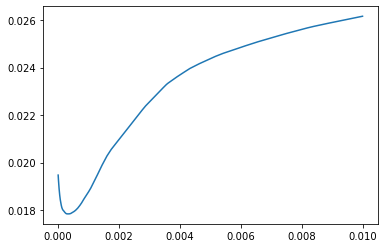

In [131]:
# Analysis for Lasso
best_alpha = lasso_reg.alpha_
coefficient = lasso_reg.coef_
non_zero_coef = [c for c in coefficient if c > 0]

print(best_alpha)
print(len(coefficient))
print(len(non_zero_coef))
mse_path_lasso = np.mean(lasso_reg.mse_path_, axis=1)
plt.plot(lasso_reg.alphas_, mse_path_lasso)

In [132]:
# grid search for xgb
xgb_model = XGBRegressor(n_jobs=1, gamma=0, n_estimators=10000)
clf = GridSearchCV(xgb_model,
    {'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
    }, verbose=1, n_jobs=1)
clf.fit(x_train, y_train)

print(clf.best_score_)
print(clf.best_params_)
best_rate_xgb = clf.best_params_['learning_rate']
best_depth_xgb = clf.best_params_['max_depth']

xgb_model = XGBRegressor(n_jobs=1, gamma=0, n_estimators=10000, learning_rate=best_rate_xgb, max_depth=best_depth_xgb)
clf = GridSearchCV(xgb_model,
    {'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
    }, verbose=1, n_jobs=1)
clf.fit(x_train, y_train)

print(clf.best_score_)
print(clf.best_params_)
best_subsample_xgb = clf.best_params_['subsample']
best_colsample_bytree_xgb = clf.best_params_['colsample_bytree']

xgb_model = XGBRegressor(n_jobs=1, 
    gamma=0, 
    n_estimators=10000, 
    learning_rate=best_rate_xgb, 
    max_depth=best_depth_xgb,
    subsample=best_subsample_xgb,
    colsample_bytree=best_colsample_bytree_xgb)
clf = GridSearchCV(xgb_model,
    {'reg_alpha': [0.5, 0.7, 0.9],
    'reg_lambda': [0.5, 0.6, 0.8]
    }, verbose=1, n_jobs=1)
clf.fit(x_train, y_train)

print(clf.best_score_)
print(clf.best_params_)
best_alpha_xgb = clf.best_params_['reg_alpha']
best_lambda_xgb = clf.best_params_['reg_lambda']

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 379.9min finished
0.8995434966482054
{'learning_rate': 0.05, 'max_depth': 4}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 56.7min finished
0.9032223884950413
{'colsample_bytree': 0.5, 'subsample': 0.8}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 840.4min finished
0.9004971536705015
{'reg_alpha': 0.9, 'reg_lambda': 0.5}


In [133]:
# grid search for catboost
cat_reg = CatBoostRegressor(iterations=20000, logging_level='Silent')
clf = GridSearchCV(cat_reg,
    {'depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    }, n_jobs=1)
clf.fit(x_train, y_train)

print(clf.best_score_)
print(clf.best_params_)
best_rate_cat = clf.best_params_['learning_rate']
best_depth_cat = clf.best_params_['depth']

0.9057236175950495
{'depth': 6, 'learning_rate': 0.01}


In [134]:
# Combining
def rmse(y1, y2):
    return np.sqrt(metrics.mean_squared_error(y1, y2))

splits = 5
kf = KFold(n_splits=splits)

errors_cat = []
errors_lasso = []
weights = np.arange(0, 1, 0.02)

cv_trainset = train_set[[c for c in train_set.columns if c not in ['Id, Training']]]

for train, test in kf.split(cv_trainset):
    trainset = cv_trainset.iloc[train, :]
    testset = cv_trainset.iloc[test, :]
    
    train_y = np.log1p(trainset['SalePrice'])
    test_y = np.log1p(testset['SalePrice'])

    train_X = trainset[[c for c in train_set.columns if c not in omit]]
    test_X = testset[[c for c in train_set.columns if c not in omit]]

    xgb = XGBRegressor(n_jobs=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.5,
        learning_rate=0.05,
        max_depth=4,
        reg_alpha=best_alpha_xgb,
        reg_lambda=best_lambda_xgb,
        n_estimators=10000).fit(train_X, train_y)

    lasso = Lasso(random_state=0, 
        max_iter=50000, 
        alpha=best_alpha).fit(train_X, train_y)

    cat = CatBoostRegressor(learning_rate=0.01, 
        iterations=20000, 
        logging_level='Silent',
        depth=6).fit(train_X, train_y)

    y_xgb = xgb.predict(test_X)
    y_lasso = lasso.predict(test_X)
    y_cat = cat.predict(test_X)

    # linear combination
    error_l = []
    for weight in weights:
        # y_test_final = y_lasso ** weight * y_xgb ** (1 - weight)
        y_test_final = y_lasso * weight + y_xgb * (1 - weight)
        error_l.append(rmse(test_y, y_test_final))
    errors_lasso.append(error_l)

    error_l = []
    for weight in weights:
        # y_test_final = y_cat ** weight * (y_xgb * y_lasso) ** ((1 - weight) / 2)
        y_test_final = y_cat * weight + (y_xgb + y_lasso) * ((1 - weight) / 2)
        error_l.append(rmse(test_y, y_test_final))
    errors_cat.append(error_l)

0.4


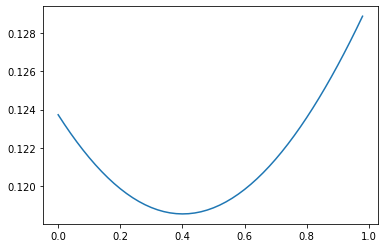

In [135]:
# best lasso weight
errors_lasso_weight = np.mean(errors_lasso, axis=0)
plt.plot(weights, errors_lasso_weight)
best_error = np.min(errors_lasso_weight)
best_weight_lasso = weights[errors_lasso_weight == best_error][0]
print(best_weight_lasso)

0.44


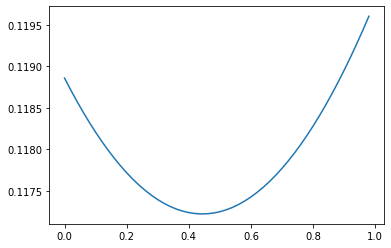

In [136]:
# best cat weight
errors_cat_weight = np.mean(errors_cat, axis=0)
plt.plot(weights, errors_cat_weight)
best_error = np.min(errors_cat_weight)
best_weight_cat = weights[errors_cat_weight == best_error][0]
print(best_weight_cat)


In [139]:
# final models
xgb = XGBRegressor(n_jobs=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.5,
    learning_rate=0.05,
    max_depth=4,
    reg_alpha=best_alpha_xgb,
    reg_lambda=best_lambda_xgb,
    n_estimators=20000).fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=100, eval_metric='rmse')

lasso = Lasso(random_state=0, 
    max_iter=50000, 
    alpha=best_alpha).fit(x_train, y_train)

cat = CatBoostRegressor(learning_rate=0.01,
    iterations=50000, 
    depth=6).fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=100)

ning: 3m 20s
2680:	learn: 0.0534777	test: 0.1086944	best: 0.1086928 (2656)	total: 11.4s	remaining: 3m 20s
2681:	learn: 0.0534679	test: 0.1086972	best: 0.1086928 (2656)	total: 11.4s	remaining: 3m 20s
2682:	learn: 0.0534504	test: 0.1087039	best: 0.1086928 (2656)	total: 11.4s	remaining: 3m 20s
2683:	learn: 0.0534350	test: 0.1087078	best: 0.1086928 (2656)	total: 11.4s	remaining: 3m 20s
2684:	learn: 0.0534267	test: 0.1087151	best: 0.1086928 (2656)	total: 11.4s	remaining: 3m 20s
2685:	learn: 0.0534179	test: 0.1087170	best: 0.1086928 (2656)	total: 11.4s	remaining: 3m 20s
2686:	learn: 0.0534076	test: 0.1087103	best: 0.1086928 (2656)	total: 11.4s	remaining: 3m 20s
2687:	learn: 0.0533927	test: 0.1087099	best: 0.1086928 (2656)	total: 11.4s	remaining: 3m 20s
2688:	learn: 0.0533812	test: 0.1087031	best: 0.1086928 (2656)	total: 11.4s	remaining: 3m 20s
2689:	learn: 0.0533677	test: 0.1086910	best: 0.1086910 (2689)	total: 11.4s	remaining: 3m 20s
2690:	learn: 0.0533582	test: 0.1086938	best: 0.1086910 (2

In [140]:
# evaluate result
# best_weight_cat = 0
# best_weight_lasso = 0.6
y_pred_xgb = xgb.predict(x_validation)
y_pred_lasso = lasso.predict(x_validation)
y_pred_cat = cat.predict(x_validation)
# y_pred = y_pred_cat ** best_weight_cat * (y_pred_lasso ** best_weight_lasso * y_pred_xgb ** (1 - best_weight_lasso)) ** (1 - best_weight_cat)
y_pred = y_pred_cat * best_weight_cat + (y_pred_lasso * best_weight_lasso + y_pred_xgb * (1 - best_weight_lasso)) * (1 - best_weight_cat)

rmse_training = rmse(y_pred, y_validation)
compare = pd.DataFrame()
compare['Predicted'] = y_pred
compare['True'] = target_y
print(rmse_training)

0.10796455871608758


In [141]:
# prediction result
y_pred_xgb = xgb.predict(X_test)
y_pred_lasso = lasso.predict(X_test)
y_pred_cat = cat.predict(X_test)
# y_pred = y_pred_cat ** best_weight_cat * (y_pred_lasso ** best_weight_lasso * y_pred_xgb ** (1 - best_weight_lasso)) ** (1 - best_weight_cat)
y_pred = y_pred_cat * best_weight_cat + (y_pred_lasso * best_weight_lasso + y_pred_xgb * (1 - best_weight_lasso)) * (1 - best_weight_cat)

y_final_test = np.exp(y_pred) - 1

In [142]:
# submission
submit = ['SalePrice', 'Id']
test_data['SalePrice'] = y_final_test
submission = test_data[[c for c in test_data.columns if c in submit]]
submission.to_csv('./data/teamJarvis_cat.csv', index=False)